In [19]:
!pip install gymnasium
!pip install pygame
!pip install numpy
!pip install torch

In [20]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [21]:
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

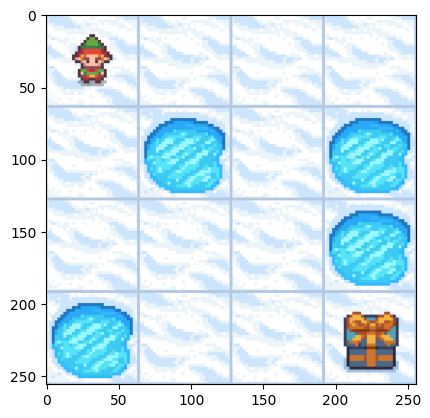

In [22]:
env=gym.make('FrozenLake-v1', render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [23]:
n_s=env.observation_space.n
n_a=env.action_space.n
n_epi=5000
disc=.95
eps=1

In [24]:
def get_in(s_bat, n_s=n_s):
  s_oh=[]
  for s in s_bat:
    oh=np.zeros(n_s)
    oh[s]=1
    s_oh.append(oh)
  return torch.Tensor(s_oh)

In [ ]:
get_in([0,5,11],n_s)

In [25]:
def pi_eps(model,s, eps):
  u=random.random()
  if u >= eps:
    a=np.argmax(model(get_in([s])).data.numpy())
  else:
    a=env.action_space.sample()
  return a

In [26]:
def get_bat(replay, n_bat):
  bat=random.sample(replay, n_bat)
  s_bat=[s for(s,a,r,s1,d) in bat]
  a_bat=torch.Tensor([a for(s,a,r,s1,d)in bat]).long()
  r_bat=torch.Tensor([r for(s,a,r,s1,d)in bat])
  s1_bat=[s1 for(s,a,r,s1,d)in bat]
  done_bat=torch.Tensor([d for(s,a,r,s1,d)in bat])
  return s_bat,a_bat,r_bat,s1_bat,done_bat

In [27]:
n_buf=10000
n_bat=200

In [28]:
replay=deque(maxlen=n_buf)

In [29]:
h1=50

In [30]:
Q_main=torch.nn.Sequential(
    torch.nn.Linear(n_s,h1), #16,50
    torch.nn.ReLU(),
    torch.nn.Linear(h1,n_a), #50,4
)

In [31]:
sync_freq=50

In [32]:
Q_tar=copy.deepcopy(Q_main)
Q_tar.load_state_dict(Q_main.state_dict())

<All keys matched successfully>

In [33]:
losses=[]

In [34]:
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(Q_main.parameters(), lr=1e-3)

In [35]:
t=0
env=gym.make('FrozenLake-v1', render_mode=None)

In [36]:
for i in tqdm(range(n_epi)):
  s,_=env.reset()
  done=False
  while not done:
    a=pi_eps(Q_main,s,eps)
    s1,r,done,_,_=env.step(a)
    replay.append((s,a,r,s1,done))
    s=s1
    if len(replay)>n_bat:
      s_bat,a_bat,r_bat,s1_bat,done_bat=get_bat(replay,n_bat)
      q_pre=Q_main(get_in(s_bat))
      y_hat=q_pre.gather(dim=1,index=a_bat.unsqueeze(dim=1)).squeeze()
      with torch.no_grad():
        q_tar_s1=Q_tar(get_in(s1_bat))
        max_q_tar_s1=torch.max(q_tar_s1,dim=1).values
        y=r_bat+(1-done_bat)*(disc*max_q_tar_s1)
      loss=loss_fn(y.detach(),y_hat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      t+=1
    if t % sync_freq == 0:
      Q_tar.load_state_dict(Q_main.state_dict())
  if eps>0.1:
    eps -=(1/n_epi)


100%|██████████| 5000/5000 [05:14<00:00, 15.87it/s]


Text(0, 0.5, 'Loss')

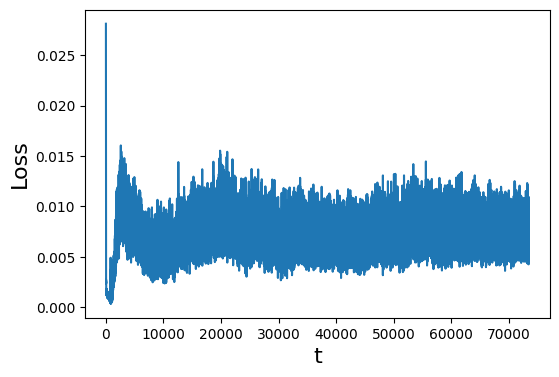

In [37]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

In [38]:
for s in range(n_s):
  print('s=',s,Q_main(get_in([s])).data.numpy())

s= 0 [[0.1901572  0.17687477 0.19001672 0.16763711]]
s= 1 [[0.12766708 0.13510895 0.12273656 0.15274268]]
s= 2 [[0.13855721 0.13169089 0.14279434 0.13035859]]
s= 3 [[0.03877095 0.04309835 0.10198523 0.12011043]]
s= 4 [[0.21893889 0.18884687 0.17672363 0.14337766]]
s= 5 [[0.21905085 0.2275796  0.2813224  0.18320721]]
s= 6 [[0.13649073 0.13388284 0.1628848  0.06525789]]
s= 7 [[0.19546095 0.24577016 0.25939345 0.18314873]]
s= 8 [[0.13541993 0.21531144 0.22857001 0.2840747 ]]
s= 9 [[0.2860186  0.38314706 0.3340064  0.2591248 ]]
s= 10 [[0.38619184 0.26864412 0.36935452 0.15828604]]
s= 11 [[0.19568565 0.26464927 0.33233884 0.24466415]]
s= 12 [[0.16801447 0.29624283 0.2799617  0.32709762]]
s= 13 [[0.26664296 0.4813968  0.527712   0.40626442]]
s= 14 [[0.5375068 0.7192567 0.7356447 0.6846163]]
s= 15 [[0.20600742 0.21642938 0.23954645 0.18974638]]


In [39]:
pi_opt=np.zeros(n_s)
for s in range(n_s):
  if s not in[5,7,11,12,15]:
    pi_opt[s]=pi_eps(Q_main,s,eps=0)
pi_opt

array([0., 3., 2., 3., 0., 0., 2., 0., 3., 1., 0., 0., 0., 2., 2., 0.])

In [40]:
def test_agent(model, n_t=100, mode='human', display=True):
  env=gym.make('FrozenLake-v1', render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    a=pi_eps(model, s, eps=0)
    s1,r,done,_,_=env.step(a)
    if display:
      print('t=',t,'s=',s,'a=',a,'r=',r,'s\'=',s1,'done',done)
      clear_output(wait=True)
    s=s1
    if done:
      if display:
        if r==1:
          print('you won! reward:%s' % (r))
        else:
          print('you lost')
      break
  if not done:
    if display:
      print('lost:too many moves.')
  win=True if r ==1 else False
  return win

In [41]:
n_t=100
test_agent(Q_main,n_t)

you won! reward:1.0


True

In [42]:
n_game=1000
n_win=0
for i in range(n_game):
  win=test_agent(Q_main, mode=None, display=False)
  if win:
    n_win+=1
win_rate=n_win/n_game
print('games play:{},#of wins:{}'.format(n_game,n_win))
print('win rate:{}%'.format(100*win_rate))


games play:1000,#of wins:637
win rate:63.7%
